In [310]:
import secrets

import easydict
import matplotlib.pyplot as plt
import torch
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torch.utils.data as data
from tqdm import tqdm
import pandas as pd
import numpy as np

# from model import LSTMVAE
from numpy import recarray
from sklearn.model_selection import train_test_split
# from dataset import mHealth
from torchvision import transforms
import torch.utils.data as data

In [311]:
class mHealth(data.Dataset):
    
    def __init__(self, dataframe, raw_data):
        """
        Args:
            csv_file (string): path to csv file with data
        """
        self.dataset = dataframe
        self.raw_data = raw_data

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        """
        Args:
            index (int): index
            
        Returns:
            (sequence, label)
            returns the time series data then label value for data
        """
        
        # label = self.raw_data['label'].iloc[index]
        
        # sequence = np.array()
        # print(self.dataset['chest acceleration X-axis'].iloc[index:index+32].type)
        # sequence = [self.dataset['chest acceleration X-axis'].iloc[index:index+32],
        #             self.dataset['chest acceleration Y-axis'].iloc[index:index+32],
        #             self.dataset['chest acceleration Z-axis'].iloc[index:index+32],]
        
        # sequence = [self.dataset['Chest X-axis'].iloc[index],
        #             self.dataset['Chest Y-axis'].iloc[index],
        #             self.dataset['Chest Z-axis'].iloc[index],]
        
        sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
        target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)
        
        # if(len(sequence) <14):
        #     print("sequence is small, index: ", index)
            
        
        # print(sequence.type)
        return sequence, target

def collate_fn(batch):
    # Get the maximum length in the batch
    max_length = max(len(x[0]) for x in batch)
    # print("maxlangth=", max_length)
    
    # Pad all sequences to the maximum length
    padded_y_batch = []
    padded_x_batch = []
    for x,y in batch:
        padded_x = torch.cat([x, torch.zeros(max_length - len(x))], dim=0)
        padded_y = torch.cat([y, torch.zeros(max_length - len(y))], dim=0)
        padded_x_batch.append((padded_x))
        padded_y_batch.append((padded_y))
    
    
    padded_x_batch = torch.stack(padded_x_batch)
    padded_y_batch = torch.stack(padded_y_batch)
    
    return padded_x_batch, padded_y_batch
#create new dataframe with each index ho lding the 32 values in the future  

In [312]:
import torch
from torch import nn
from torch.nn import functional as F


class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )

    def forward(self, x):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        # x = x.view(*x.shape, 64)
        x = x.unsqueeze(dim=0)
        x = x.permute(1, 2, 0)
        # print("encoder x shape: ", x.shape)
        outputs, (hidden, cell) = self.lstm(x)
        # print("failed")
        # print("enc output shape: ", outputs.shape)
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=1, hidden_size=64, output_size=1, num_layers=2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x = x.reshape(512, 64, 1)
        hidden = (hidden[0].unsqueeze(dim=0), hidden[1].unsqueeze(dim=0))
        # hidden = (hidden[0].permute(0, 1, 2), hidden[1].permute(1, 2,0))
        # print("hidden shape 0: ", hidden[0].shape)
        # print("hidden shape 1: ", hidden[1].shape)
        # print("decoder x shape: ", x.shape)
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        
        output, (hidden, cell) = self.lstm(x, hidden)
        # print("got here")
        prediction = self.fc(output)
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, hidden_size, latent_size, device
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size of LSTM AE
        latent_size: int, latent z-layer size
        num_lstm_layer: int, number of layers in LSTM
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 1

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=1, 
            hidden_size=hidden_size, 
            num_layers=self.num_layers
        )
        
        self.lstm_dec = Decoder(
            input_size=1,
            output_size=1,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )
        # self.lstm_dec = Decoder(
        #     input_size=latent_size,
        #     output_size=input_size,
        #     hidden_size=hidden_size,
        #     num_layers=self.num_layers,
        # )

        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        x = x.squeeze()
        # print("x shape: ", x.shape)
        batch_size, seq_len = x.shape
        feature_dim = 1

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        # print("enc out shape: ", outputs.shape)
        # print("enchidden 0 shape: ", enc_hidden[0].shape)
        # print("enchidden 1 shape: ", enc_hidden[1].shape)
        # print("got here line 99")
        
        # enc_h = enc_hidden[0].view(self.hidden_size).to(self.device)
        enc_h = enc_hidden[0].view(batch_size, self.hidden_size).to(self.device)
        # print("passed")
        # print("enc_h shape: ", enc_h.shape)
        # extract latent variable z(hidden space to latent space)
        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size

        # initialize hidden state as inputs
        h_ = self.fc3(z)
        
        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        # z = z.view(batch_size, seq_len, self.latent_size).to(self.device)
        z = z.view(batch_size, seq_len, self.latent_size).to(self.device)
        # print("z shape:", z.shape)
        # initialize hidden state
        hidden = (h_.contiguous(), h_.contiguous())
        # print("got here 2")
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        # print("reconstruction output shape: ", reconstruct_output.shape)
        # print("hidden shape [0]: ", hidden[0].shape)
        # print("hidden shape [1]: ", hidden[1].shape)
        x_hat = reconstruct_output

        # calculate vae loss
        # print(x.shape)
        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset
        
        # recons = recons.reshape(4, 16)
        recons = recons.reshape(64, 512, 1)
        # print("recons shape: ", recons.shape)
        # print("input shape: ", input.shape)
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }
    
    # def loss_function(recon_x, x, mu, logvar):
    #     BCE = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
    #     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #     return BCE + KLD


# class LSTMAE(nn.Module):
#     """LSTM-based Auto Encoder"""

#     def __init__(self, input_size, hidden_size, latent_size, device):
#         """
#         input_size: int, batch_size x sequence_length x input_dim
#         hidden_size: int, output size of LSTM AE
#         latent_size: int, latent z-layer size
#         num_lstm_layer: int, number of layers in LSTM
#         """
#         super(LSTMAE, self).__init__()
#         self.device = device

#         # dimensions
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.latent_size = latent_size

#         # lstm ae
#         self.lstm_enc = Encoder(
#             input_size=input_size,
#             hidden_size=hidden_size,
#         )
#         self.lstm_dec = Decoder(
#             input_size=input_size,
#             output_size=input_size,
#             hidden_size=hidden_size,
#         )

#         self.criterion = nn.MSELoss()

#     def forward(self, x):
#         batch_size, seq_len, feature_dim = x.shape

#         enc_hidden = self.lstm_enc(x)

#         temp_input = torch.zeros((batch_size, seq_len, feature_dim), dtype=torch.float).to(
#             self.device
#         )
#         hidden = enc_hidden
#         reconstruct_output, hidden = self.lstm_dec(temp_input, hidden)
#         reconstruct_loss = self.criterion(reconstruct_output, x)

#         return reconstruct_loss, reconstruct_output, (0, 0)

<>:166: SyntaxWarning: invalid escape sequence '\m'
<>:166: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_84572/1913242382.py:166: SyntaxWarning: invalid escape sequence '\m'
  """


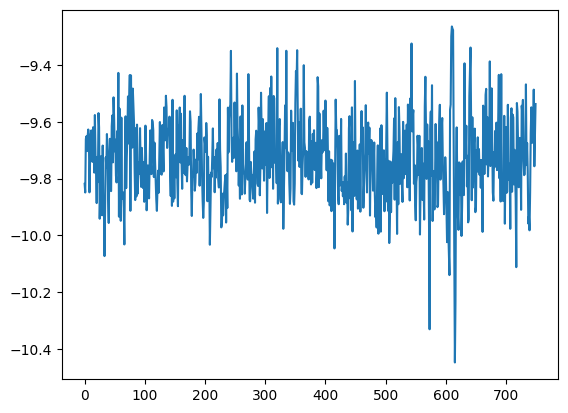

In [313]:
dataset = pd.read_csv('/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV/mHealth_subject1.csv')
dataset = dataset['chest acceleration X-axis']
plt.plot(dataset[:750])

In [314]:
# dataframe = pd.read_csv('/home/jm/vscode/Python/pythonenv/gait-project/VAE+RNN/lstm_vae_2/processed_data/chest_accel.csv')

In [315]:
dataset = torch.tensor(dataset)
dataset.shape

torch.Size([161280])

In [316]:
split_idx = int(len(dataset) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
    raw_data=dataset
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
    raw_data=dataset
)

batch_size = 512
input_size = 16
hidden_size = 64
latent_size = 4
num_layers = 2

# if torch.cuda.is_available(): 
#     device = 'cuda' 
#     print("cuda")
# else: 
device = 'cpu'
print("cpu")

# define LSTM-based VAE model
model = LSTMVAE(input_size, hidden_size, latent_size, device=device)

cpu


In [317]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")

# test_loader = torch.utils.data.DataLoader(
#     dataset=test_set, 
#     batch_size=args.batch_size, 
#     shuffle=False,
#     drop_last=True
# )

for idx, data in enumerate(train_loader):
    datas = data[0]
    labels = data[1]
    print(datas)
    break
    print("Data shape:", datas.shape)
    #print("Labels:", labels)
   # ("Labels shape:", len(labels))
    print("labels shape", labels.shape)
    break

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x7d588fbf3620>
Length of train_dataloader: 63 batches of 512
tensor([[ -9.0151, -10.2780, -11.2820,  ...,  -9.1490,  -9.7478,  -9.1239],
        [ -9.2143,  -8.9875,  -9.0604,  ..., -10.0110, -10.4120, -10.7020],
        [-12.6500, -12.8500, -12.7530,  ...,  -8.4795,  -6.6662,  -6.3269],
        ...,
        [ -7.4718,  -8.3780,  -8.4019,  ...,  -8.2989,  -8.5421,  -7.3527],
        [ -8.9715,  -8.9784,  -9.1290,  ...,  -4.3269,  -6.2375, -11.0770],
        [-13.1080, -12.3520, -12.1190,  ...,  -7.9214,  -7.9760,  -7.5985]])


/tmp/ipykernel_84572/3590410135.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
/tmp/ipykernel_84572/3590410135.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)


In [318]:
def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    ## interation setup
    epochs = tqdm(range(iterations))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )

        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data, future_data = batch_data
            # print("past_data shape: ", past_data.shape)

            ## reshape
            # batch_size = past_data.size(0)
            # example_size = past_data.size(1)
            # image_size = past_data.size(2), past_data.size(3)
            # past_data = (
            #     past_data.view(batch_size, example_size, -1).float().to(args.device)
            # )
            # future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

            mloss, recon_x, info = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
        # writer.add_scalar("train_loss", float(mloss.mean()), epoch)

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                future_data, past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )
                # future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"eval_loss": float(mloss.mean())})

                # if i == 0:
                #     nhw_orig = past_data[0].view(example_size, image_size[0], -1)
                #     nhw_recon = recon_x[0].view(example_size, image_size[0], -1)
                #     imshow(nhw_orig.cpu(), f"orig{epoch}")
                #     imshow(nhw_recon.cpu(), f"recon{epoch}")
                #     # writer.add_images(f"original{i}", nchw_orig, epoch)
                #     # writer.add_images(f"reconstructed{i}", nchw_recon, epoch)

        eval_loss = eval_loss / len(test_loader)
        # writer.add_scalar("eval_loss", float(eval_loss), epoch)
        print("Evaluation Score : [{}]".format(eval_loss))

    return model


In [319]:
iterations = 100000
train(iterations, model, train_loader, train_loader)

  0%|          | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_84572/3590410135.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
/tmp/ipykernel_84572/3590410135.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)
/tmp/ipykernel_84572/1913242382.py:184: UserWarning: Using a target size (torch.Size([512, 16])) that is different to the input size (torch.Size([64, 512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recons_loss = F.mse_loss(recons, input)
training: 63it [00:04, 12.91i

Evaluation Score : [61.20339293706985]


training: 63it [00:05, 11.09it/s, train_loss=23.8]
  0%|          | 2/100000 [00:14<206:08:13,  7.42s/it]

Evaluation Score : [24.304983017936586]


training: 63it [00:05, 12.40it/s, train_loss=6.48]
  0%|          | 3/100000 [00:21<201:03:06,  7.24s/it]

Evaluation Score : [11.157331860254681]


training: 63it [00:05, 12.34it/s, train_loss=6.41]
  0%|          | 4/100000 [00:28<199:41:09,  7.19s/it]

Evaluation Score : [11.237703505016508]


training: 63it [00:05, 12.58it/s, train_loss=6.22]
  0%|          | 5/100000 [00:35<197:20:59,  7.10s/it]

Evaluation Score : [11.182088745964897]


training: 63it [00:05, 11.63it/s, train_loss=6.24]
  0%|          | 6/100000 [00:43<200:45:40,  7.23s/it]

Evaluation Score : [11.11631687103756]


training: 63it [00:04, 13.08it/s, train_loss=5.96]
  0%|          | 7/100000 [00:50<197:03:16,  7.09s/it]

Evaluation Score : [11.073333225552998]


training: 63it [00:05, 12.57it/s, train_loss=5.8]
  0%|          | 8/100000 [00:57<195:53:22,  7.05s/it]

Evaluation Score : [11.028808608887688]


training: 63it [00:04, 12.85it/s, train_loss=5.55]
  0%|          | 9/100000 [01:03<194:09:09,  6.99s/it]

Evaluation Score : [10.993713742210751]


training: 63it [00:05, 12.32it/s, train_loss=6.23]
  0%|          | 10/100000 [01:11<195:55:13,  7.05s/it]

Evaluation Score : [10.945703824361166]


training: 63it [00:05, 12.32it/s, train_loss=5.67]
  0%|          | 11/100000 [01:18<196:11:41,  7.06s/it]

Evaluation Score : [10.921828769502186]


training: 63it [00:05, 12.34it/s, train_loss=5.57]
  0%|          | 12/100000 [01:25<196:34:41,  7.08s/it]

Evaluation Score : [10.890107805766757]


training: 63it [00:04, 13.16it/s, train_loss=5.92]
  0%|          | 13/100000 [01:32<193:52:33,  6.98s/it]

Evaluation Score : [10.861045837402344]


training: 63it [00:04, 12.62it/s, train_loss=5.73]
  0%|          | 14/100000 [01:39<193:42:23,  6.97s/it]

Evaluation Score : [10.833865771217951]


training: 63it [00:05, 12.11it/s, train_loss=6.02]
  0%|          | 15/100000 [01:46<195:15:17,  7.03s/it]

Evaluation Score : [10.823567587231834]


training: 63it [00:05, 12.35it/s, train_loss=5.88]
  0%|          | 16/100000 [01:53<195:50:47,  7.05s/it]

Evaluation Score : [10.772566129290869]


training: 63it [00:05, 12.27it/s, train_loss=5.5]
  0%|          | 17/100000 [02:00<196:11:59,  7.06s/it]

Evaluation Score : [10.755174742804634]


training: 63it [00:04, 12.77it/s, train_loss=5.63]
  0%|          | 18/100000 [02:07<196:10:06,  7.06s/it]

Evaluation Score : [10.744616478208512]


training: 63it [00:04, 12.79it/s, train_loss=5.71]
  0%|          | 19/100000 [02:14<194:23:12,  7.00s/it]

Evaluation Score : [10.734980083647228]


training: 63it [00:04, 12.83it/s, train_loss=5.53]
  0%|          | 20/100000 [02:21<193:39:22,  6.97s/it]

Evaluation Score : [10.713522865658714]


training: 63it [00:04, 13.05it/s, train_loss=5.42]
  0%|          | 21/100000 [02:28<192:23:12,  6.93s/it]

Evaluation Score : [10.694728124709357]


training: 63it [00:05, 12.54it/s, train_loss=5.75]
  0%|          | 22/100000 [02:35<194:13:13,  6.99s/it]

Evaluation Score : [10.676714654952761]


training: 63it [00:04, 12.73it/s, train_loss=5.76]
  0%|          | 23/100000 [02:42<194:04:35,  6.99s/it]

Evaluation Score : [10.674028956700885]


training: 63it [00:04, 13.02it/s, train_loss=5.82]
  0%|          | 24/100000 [02:48<192:41:17,  6.94s/it]

Evaluation Score : [10.667009686666821]


training: 63it [00:04, 12.91it/s, train_loss=5.42]
  0%|          | 25/100000 [02:55<192:24:42,  6.93s/it]

Evaluation Score : [10.657704141404894]


training: 63it [00:04, 12.72it/s, train_loss=5.55]
  0%|          | 26/100000 [03:02<192:45:13,  6.94s/it]

Evaluation Score : [10.643300540863521]


training: 63it [00:05, 12.54it/s, train_loss=5.62]
  0%|          | 27/100000 [03:09<193:09:39,  6.96s/it]

Evaluation Score : [10.64337542700389]


training: 63it [00:04, 12.78it/s, train_loss=5.69]
  0%|          | 28/100000 [03:16<192:47:25,  6.94s/it]

Evaluation Score : [10.637920061747232]


training: 63it [00:04, 12.98it/s, train_loss=5.52]
  0%|          | 29/100000 [03:23<191:35:45,  6.90s/it]

Evaluation Score : [10.623291167001875]


training: 63it [00:04, 12.74it/s, train_loss=5.48]
  0%|          | 30/100000 [03:30<191:55:16,  6.91s/it]

Evaluation Score : [10.627534306238568]


training: 63it [00:05, 12.35it/s, train_loss=5.34]
  0%|          | 31/100000 [03:37<193:26:27,  6.97s/it]

Evaluation Score : [10.617528097970146]


training: 63it [00:04, 12.77it/s, train_loss=5.6]
  0%|          | 32/100000 [03:44<193:18:22,  6.96s/it]

Evaluation Score : [10.619155747549874]


training: 63it [00:04, 12.70it/s, train_loss=5.45]
  0%|          | 33/100000 [03:51<193:03:02,  6.95s/it]

Evaluation Score : [10.620077118041023]


training: 63it [00:05, 12.60it/s, train_loss=5.46]
  0%|          | 34/100000 [03:58<193:12:06,  6.96s/it]

Evaluation Score : [10.609735155862476]


training: 63it [00:04, 12.60it/s, train_loss=5.63]
  0%|          | 35/100000 [04:05<193:30:28,  6.97s/it]

Evaluation Score : [10.611083772447374]


training: 63it [00:04, 12.73it/s, train_loss=5.74]
  0%|          | 36/100000 [04:12<192:56:20,  6.95s/it]

Evaluation Score : [10.607786496480307]


training: 63it [00:04, 12.75it/s, train_loss=5.42]
  0%|          | 37/100000 [04:19<193:08:34,  6.96s/it]

Evaluation Score : [10.614542446439229]


training: 63it [00:04, 12.60it/s, train_loss=5.57]
  0%|          | 38/100000 [04:26<193:13:19,  6.96s/it]

Evaluation Score : [10.609439607650515]


training: 63it [00:04, 12.89it/s, train_loss=5.2]
  0%|          | 39/100000 [04:33<193:38:52,  6.97s/it]

Evaluation Score : [10.605834325154623]


training: 63it [00:04, 12.74it/s, train_loss=5.71]
  0%|          | 40/100000 [04:40<193:23:56,  6.97s/it]

Evaluation Score : [10.611895061674572]


training: 63it [00:04, 12.75it/s, train_loss=5.38]
  0%|          | 41/100000 [04:47<193:15:12,  6.96s/it]

Evaluation Score : [10.603747049967447]


training: 63it [00:04, 12.65it/s, train_loss=5.85]
  0%|          | 42/100000 [04:54<192:58:18,  6.95s/it]

Evaluation Score : [10.60848021128821]


training: 63it [00:04, 12.87it/s, train_loss=5.37]
  0%|          | 43/100000 [05:01<193:04:14,  6.95s/it]

Evaluation Score : [10.60081692347451]


training: 63it [00:04, 12.69it/s, train_loss=5.75]
  0%|          | 44/100000 [05:08<193:16:04,  6.96s/it]

Evaluation Score : [10.608537567986382]


training: 63it [00:04, 12.61it/s, train_loss=5.79]
  0%|          | 45/100000 [05:15<193:26:43,  6.97s/it]

Evaluation Score : [10.614818830338736]


training: 63it [00:04, 12.65it/s, train_loss=5.71]
  0%|          | 46/100000 [05:21<193:34:50,  6.97s/it]

Evaluation Score : [10.605010653298999]


training: 63it [00:05, 12.12it/s, train_loss=5.51]
  0%|          | 47/100000 [05:29<195:29:05,  7.04s/it]

Evaluation Score : [10.609858073885478]


training: 63it [00:05, 12.16it/s, train_loss=5.61]
  0%|          | 48/100000 [05:36<196:35:25,  7.08s/it]

Evaluation Score : [10.617271181136843]


training: 63it [00:04, 12.82it/s, train_loss=5.59]
  0%|          | 49/100000 [05:43<195:23:32,  7.04s/it]

Evaluation Score : [10.604820160638718]


training: 63it [00:04, 12.90it/s, train_loss=5.64]
  0%|          | 50/100000 [05:50<193:50:47,  6.98s/it]

Evaluation Score : [10.609562313745892]


training: 63it [00:04, 12.82it/s, train_loss=5.65]
  0%|          | 51/100000 [05:57<193:15:29,  6.96s/it]

Evaluation Score : [10.614442643665132]


training: 63it [00:05, 12.56it/s, train_loss=5.4]
  0%|          | 52/100000 [06:04<193:41:19,  6.98s/it]

Evaluation Score : [10.602970077877952]


training: 63it [00:04, 12.77it/s, train_loss=5.32]
  0%|          | 53/100000 [06:10<193:04:58,  6.95s/it]

Evaluation Score : [10.605067798069545]


training: 63it [00:04, 12.70it/s, train_loss=5.73]
  0%|          | 54/100000 [06:17<192:57:03,  6.95s/it]

Evaluation Score : [10.608311516898018]


training: 63it [00:04, 12.84it/s, train_loss=5.48]
  0%|          | 55/100000 [06:24<192:27:42,  6.93s/it]

Evaluation Score : [10.613917471870543]


training: 63it [00:04, 12.66it/s, train_loss=5.9]
  0%|          | 56/100000 [06:31<192:47:52,  6.94s/it]

Evaluation Score : [10.613411615765283]


training: 63it [00:04, 12.83it/s, train_loss=6.04]
  0%|          | 57/100000 [06:38<192:28:23,  6.93s/it]

Evaluation Score : [10.608503477913994]


training: 63it [00:04, 12.77it/s, train_loss=5.56]
  0%|          | 58/100000 [06:45<192:25:11,  6.93s/it]

Evaluation Score : [10.616317991226438]


training: 63it [00:05, 12.54it/s, train_loss=5.76]
  0%|          | 59/100000 [06:52<193:22:24,  6.97s/it]

Evaluation Score : [10.611873732672798]


training: 63it [00:04, 12.62it/s, train_loss=5.69]
  0%|          | 60/100000 [06:59<194:22:37,  7.00s/it]

Evaluation Score : [10.612207397582038]


training: 63it [00:04, 12.77it/s, train_loss=5.29]
  0%|          | 61/100000 [07:06<193:26:39,  6.97s/it]

Evaluation Score : [10.61650816599528]


training: 63it [00:04, 12.89it/s, train_loss=5.7]
  0%|          | 62/100000 [07:13<192:43:30,  6.94s/it]

Evaluation Score : [10.61707605634417]


training: 63it [00:04, 12.68it/s, train_loss=5.62]
  0%|          | 63/100000 [07:20<192:37:35,  6.94s/it]

Evaluation Score : [10.613448657686748]


training: 63it [00:04, 12.81it/s, train_loss=5.17]
  0%|          | 64/100000 [07:27<192:31:40,  6.94s/it]

Evaluation Score : [10.612261439126636]


training: 63it [00:05, 12.12it/s, train_loss=5.51]
  0%|          | 65/100000 [07:34<194:42:19,  7.01s/it]

Evaluation Score : [10.616354412502712]


training: 63it [00:04, 12.77it/s, train_loss=5.55]
  0%|          | 66/100000 [07:41<194:02:54,  6.99s/it]

Evaluation Score : [10.615524549332877]


training: 63it [00:04, 12.73it/s, train_loss=5.22]
  0%|          | 67/100000 [07:48<193:38:49,  6.98s/it]

Evaluation Score : [10.620481960357182]


training: 63it [00:05, 12.54it/s, train_loss=5.68]
  0%|          | 68/100000 [07:55<193:36:31,  6.97s/it]

Evaluation Score : [10.61754998706636]


training: 63it [00:05, 12.32it/s, train_loss=4.74]
  0%|          | 69/100000 [08:02<194:20:39,  7.00s/it]

Evaluation Score : [10.622063470265221]


training: 63it [00:04, 12.88it/s, train_loss=5.69]
  0%|          | 70/100000 [08:09<192:49:55,  6.95s/it]

Evaluation Score : [10.620184792412651]


training: 63it [00:04, 12.64it/s, train_loss=5.65]
  0%|          | 71/100000 [08:16<192:47:09,  6.95s/it]

Evaluation Score : [10.62677113972013]


training: 63it [00:05, 12.44it/s, train_loss=5.83]
  0%|          | 72/100000 [08:23<194:12:42,  7.00s/it]

Evaluation Score : [10.610374314444405]


training: 63it [00:05, 12.26it/s, train_loss=5.57]
  0%|          | 73/100000 [08:30<194:55:40,  7.02s/it]

Evaluation Score : [10.622238204592751]


training: 63it [00:04, 12.67it/s, train_loss=5.3]
  0%|          | 74/100000 [08:37<194:26:32,  7.01s/it]

Evaluation Score : [10.614179626343743]


training: 63it [00:04, 12.93it/s, train_loss=5.5]
  0%|          | 75/100000 [08:44<193:11:16,  6.96s/it]

Evaluation Score : [10.614914894104004]


training: 63it [00:04, 13.19it/s, train_loss=5.93]
  0%|          | 76/100000 [08:51<191:23:36,  6.90s/it]

Evaluation Score : [10.61172178056505]


training: 63it [00:05, 12.48it/s, train_loss=5.78]
  0%|          | 77/100000 [08:58<193:11:07,  6.96s/it]

Evaluation Score : [10.616612555488707]


training: 63it [00:05, 12.47it/s, train_loss=5.69]
  0%|          | 78/100000 [09:05<193:51:33,  6.98s/it]

Evaluation Score : [10.621189162844704]


training: 63it [00:04, 12.72it/s, train_loss=5.49]
  0%|          | 79/100000 [09:12<193:32:39,  6.97s/it]

Evaluation Score : [10.624863987877255]


training: 63it [00:04, 12.68it/s, train_loss=5.2]
  0%|          | 80/100000 [09:19<193:24:21,  6.97s/it]

Evaluation Score : [10.627864746820359]


training: 63it [00:04, 12.80it/s, train_loss=5.51]
  0%|          | 81/100000 [09:26<193:50:43,  6.98s/it]

Evaluation Score : [10.62492741478814]


training: 63it [00:05, 12.57it/s, train_loss=6]
  0%|          | 82/100000 [09:33<193:56:52,  6.99s/it]

Evaluation Score : [10.618579985603454]


training: 63it [00:04, 12.89it/s, train_loss=5.51]
  0%|          | 83/100000 [09:39<193:02:12,  6.96s/it]

Evaluation Score : [10.613715716770717]


training: 63it [00:04, 12.76it/s, train_loss=6.15]
  0%|          | 84/100000 [09:46<192:46:19,  6.95s/it]

Evaluation Score : [10.628016698928107]


training: 63it [00:04, 12.72it/s, train_loss=5.34]
  0%|          | 85/100000 [09:53<192:53:45,  6.95s/it]

Evaluation Score : [10.61631835453094]


training: 63it [00:05, 12.48it/s, train_loss=5.59]
  0%|          | 86/100000 [10:00<193:20:50,  6.97s/it]

Evaluation Score : [10.61905680762397]


training: 63it [00:04, 12.85it/s, train_loss=5.53]
  0%|          | 87/100000 [10:07<192:51:43,  6.95s/it]

Evaluation Score : [10.61922866579086]


training: 63it [00:04, 12.98it/s, train_loss=5.73]
  0%|          | 88/100000 [10:14<191:55:24,  6.92s/it]

Evaluation Score : [10.617712565830775]


training: 63it [00:04, 13.09it/s, train_loss=5.85]
  0%|          | 89/100000 [10:21<189:55:48,  6.84s/it]

Evaluation Score : [10.624852922227648]


training: 63it [00:05, 12.51it/s, train_loss=5.2]
  0%|          | 90/100000 [10:28<191:23:48,  6.90s/it]

Evaluation Score : [10.620572286938865]


training: 63it [00:04, 12.87it/s, train_loss=5.77]
  0%|          | 91/100000 [10:35<191:19:31,  6.89s/it]

Evaluation Score : [10.622133466932508]


training: 63it [00:04, 12.96it/s, train_loss=5.7]
  0%|          | 92/100000 [10:42<191:12:42,  6.89s/it]

Evaluation Score : [10.61789247724745]


training: 63it [00:04, 12.77it/s, train_loss=5.48]
  0%|          | 93/100000 [10:48<190:56:19,  6.88s/it]

Evaluation Score : [10.629922231038412]


training: 63it [00:05, 12.48it/s, train_loss=5.42]
  0%|          | 94/100000 [10:55<192:11:13,  6.93s/it]

Evaluation Score : [10.623039805699909]


training: 63it [00:04, 12.70it/s, train_loss=5.62]
  0%|          | 95/100000 [11:02<192:21:38,  6.93s/it]

Evaluation Score : [10.62425683036683]


training: 63it [00:04, 12.80it/s, train_loss=5.77]
  0%|          | 96/100000 [11:09<192:36:23,  6.94s/it]

Evaluation Score : [10.629226063925122]


training: 63it [00:04, 12.71it/s, train_loss=5.79]
  0%|          | 97/100000 [11:16<192:37:38,  6.94s/it]

Evaluation Score : [10.62553962828621]


training: 63it [00:05, 12.35it/s, train_loss=5.49]
  0%|          | 98/100000 [11:23<194:09:32,  7.00s/it]

Evaluation Score : [10.620892312791613]


training: 63it [00:04, 12.94it/s, train_loss=5.54]
  0%|          | 99/100000 [11:30<192:06:39,  6.92s/it]

Evaluation Score : [10.620789437066941]


training: 63it [00:04, 12.69it/s, train_loss=5.85]
  0%|          | 100/100000 [11:37<191:00:56,  6.88s/it]

Evaluation Score : [10.623214252411373]


training: 63it [00:04, 13.56it/s, train_loss=5.44]
  0%|          | 101/100000 [11:44<188:45:41,  6.80s/it]

Evaluation Score : [10.620623497735886]


training: 63it [00:04, 12.89it/s, train_loss=5.18]
  0%|          | 102/100000 [11:50<188:51:26,  6.81s/it]

Evaluation Score : [10.614717634897383]


training: 63it [00:04, 12.87it/s, train_loss=5.96]
  0%|          | 103/100000 [11:57<188:36:23,  6.80s/it]

Evaluation Score : [10.627849518306672]


training: 63it [00:04, 12.92it/s, train_loss=5.39]
  0%|          | 104/100000 [12:04<188:40:34,  6.80s/it]

Evaluation Score : [10.627508950611901]


training: 63it [00:04, 13.43it/s, train_loss=5.21]
  0%|          | 105/100000 [12:10<186:15:04,  6.71s/it]

Evaluation Score : [10.62535932328966]


training: 63it [00:04, 13.14it/s, train_loss=5.43]
  0%|          | 106/100000 [12:17<186:03:55,  6.71s/it]

Evaluation Score : [10.622717554607089]


training: 63it [00:04, 13.13it/s, train_loss=5.45]
  0%|          | 107/100000 [12:24<186:29:20,  6.72s/it]

Evaluation Score : [10.630600232926627]


training: 63it [00:04, 12.91it/s, train_loss=5.53]
  0%|          | 108/100000 [12:31<187:26:25,  6.76s/it]

Evaluation Score : [10.624608539399647]


training: 63it [00:04, 13.10it/s, train_loss=5.81]
  0%|          | 109/100000 [12:38<187:47:26,  6.77s/it]

Evaluation Score : [10.623531159900484]


training: 63it [00:04, 13.10it/s, train_loss=5.69]
  0%|          | 110/100000 [12:44<187:02:00,  6.74s/it]

Evaluation Score : [10.621691991412451]


training: 63it [00:04, 13.15it/s, train_loss=5.49]
  0%|          | 111/100000 [12:51<186:29:12,  6.72s/it]

Evaluation Score : [10.624649290054563]


training: 63it [00:04, 13.01it/s, train_loss=5.53]
  0%|          | 112/100000 [12:58<185:58:29,  6.70s/it]

Evaluation Score : [10.6220303944179]


training: 63it [00:04, 13.16it/s, train_loss=5.84]
  0%|          | 113/100000 [13:04<186:02:41,  6.71s/it]

Evaluation Score : [10.622515890333387]


training: 63it [00:04, 13.25it/s, train_loss=6.14]
  0%|          | 114/100000 [13:11<186:27:53,  6.72s/it]

Evaluation Score : [10.623583884466262]


training: 63it [00:04, 13.22it/s, train_loss=5.62]
  0%|          | 115/100000 [13:18<187:19:09,  6.75s/it]

Evaluation Score : [10.630911539471338]


training: 63it [00:04, 13.08it/s, train_loss=5.37]
  0%|          | 116/100000 [13:25<187:40:13,  6.76s/it]

Evaluation Score : [10.624268562074692]


training: 63it [00:04, 12.83it/s, train_loss=5.78]
  0%|          | 117/100000 [13:32<188:36:58,  6.80s/it]

Evaluation Score : [10.626531691778274]


training: 63it [00:04, 13.20it/s, train_loss=5.64]
  0%|          | 118/100000 [13:38<187:43:04,  6.77s/it]

Evaluation Score : [10.625712697468106]


training: 63it [00:04, 13.32it/s, train_loss=5.69]
  0%|          | 119/100000 [13:45<187:44:01,  6.77s/it]

Evaluation Score : [10.625256296188113]


training: 63it [00:04, 13.06it/s, train_loss=5.05]
  0%|          | 120/100000 [13:52<187:47:23,  6.77s/it]

Evaluation Score : [10.632922354198637]


training: 63it [00:04, 12.70it/s, train_loss=5.92]
  0%|          | 120/100000 [13:57<193:41:32,  6.98s/it]


KeyboardInterrupt: 

In [ ]:
# # training
# # train(args, model, train_loader, test_loader)

# def loss_function(recon_x, x, mu, logvar):
#     BCE = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# trainer(model, train_loader)

In [ ]:
# # save model
# id_ = secrets.token_hex(nbytes=4)
# torch.save(model.state_dict(), f"lstmvae{id_}.model")

# # load model
# model_to_load = LSTMVAE(input_size, hidden_size, latent_size, device=args.device)
# model_to_load.to(args.device)
# model_to_load.load_state_dict(torch.load(f"lstmvae{id_}.model"))
# model_to_load.eval()

# # show results
# ## past_data, future_data -> shape: (10,10)
# future_data, past_data = train_set[0]

# ## reshape
# example_size = past_data.size(0)
# image_size = past_data.size(1), past_data.size(2)
# past_data = past_data.view(example_size, -1).float().to(args.device)
# _, recon_data, info = model_to_load(past_data.unsqueeze(0))

# nhw_orig = past_data.view(example_size, image_size[0], -1).cpu()
# nhw_recon = (
#     recon_data.squeeze(0)
#     .view(example_size, image_size[0], -1)
#     .detach()
#     .cpu()
#     .numpy()
# )

#     imshow(nhw_orig, title=f"final_input{id_}")
#     imshow(nhw_recon, title=f"final_output{id_}")
#     plt.show()